In [1]:
import theano.tensor as tt
import pysal as ps
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import numpy as np
import pandas as pd
import ops
import distributions as spdist
import scipy.sparse as spar
import scipy.sparse.linalg as spla
import pymc3 as mc
%matplotlib inline

/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = ps.pdio.read_files(ps.examples.get_path('south.shp'))
df = df.query('STATE_NAME in ("Texas", "Oklahoma")')

In [3]:
df.columns

Index(['FIPSNO', 'NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS', 'FIPS',
       'STFIPS', 'COFIPS', 'SOUTH', 'HR60', 'HR70', 'HR80', 'HR90', 'HC60',
       'HC70', 'HC80', 'HC90', 'PO60', 'PO70', 'PO80', 'PO90', 'RD60', 'RD70',
       'RD80', 'RD90', 'PS60', 'PS70', 'PS80', 'PS90', 'UE60', 'UE70', 'UE80',
       'UE90', 'DV60', 'DV70', 'DV80', 'DV90', 'MA60', 'MA70', 'MA80', 'MA90',
       'POL60', 'POL70', 'POL80', 'POL90', 'DNL60', 'DNL70', 'DNL80', 'DNL90',
       'MFIL59', 'MFIL69', 'MFIL79', 'MFIL89', 'FP59', 'FP69', 'FP79', 'FP89',
       'BLK60', 'BLK70', 'BLK80', 'BLK90', 'GI59', 'GI69', 'GI79', 'GI89',
       'FH60', 'FH70', 'FH80', 'FH90', 'geometry'],
      dtype='object')

In [4]:
df['TEX'] = (df.STATE_NAME == 'Texas').astype(int)

In [5]:
yname = 'FH90'
xnames = ['GI89', 'HR90', 'POL90', 'UE90', 'FH80', 'TEX']
Y = df[yname].values
X = df[xnames].values
N,P = X.shape

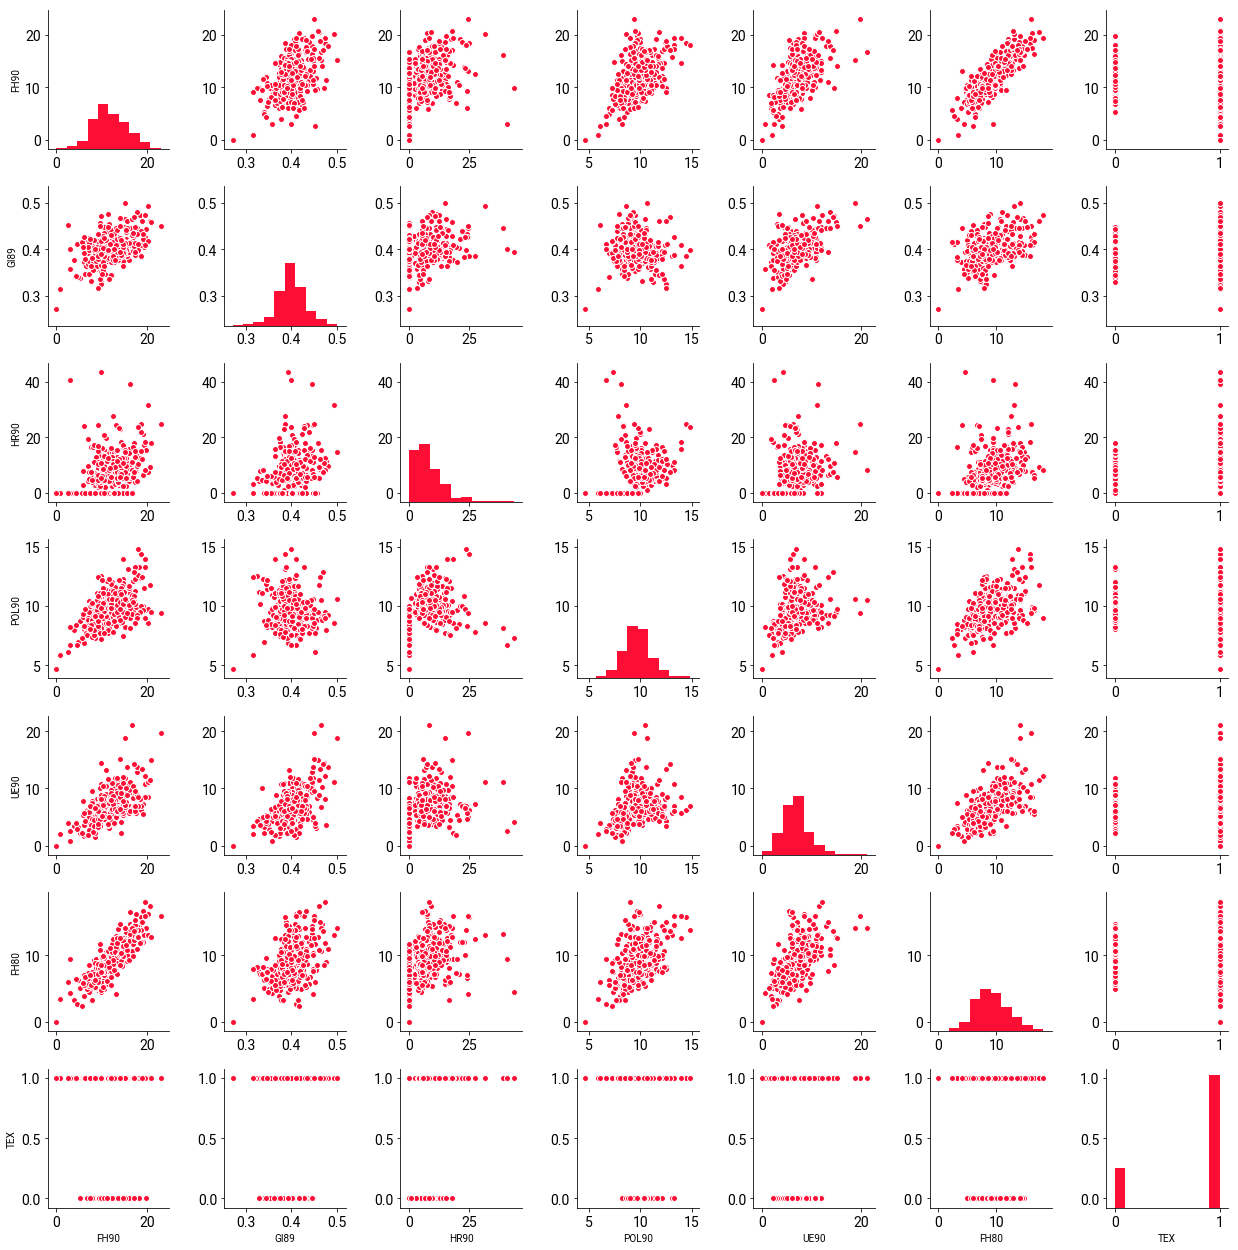

In [6]:
sns.pairplot(pd.DataFrame([Y.flatten(),*X.T], index = [yname] + xnames).T)

In [7]:
W = ps.weights.Queen.from_dataframe(df)

In [8]:
W.transform = 'r'

In [9]:
known_beta =  np.asarray([[4], [-2], [4], [-5], [1], [9], [20]])

In [10]:
Yknown = known_beta[0] + X.dot(known_beta[1:])

In [11]:
Yknown_e = Yknown + np.linalg.solve((np.eye(W.n) - .45 * W.sparse.toarray()), 
                                    np.random.normal(0,1,size=(W.n,1)))
Yknown_l = np.linalg.solve((np.eye(W.n) - .45 * W.sparse.toarray()), Yknown + np.random.normal(0,1,size=(W.n,1)))
Yknown_norm = Yknown + np.random.normal(0,1,size=(W.n,1))

In [12]:
se_pysal = ps.spreg.ML_Error(Yknown_e, X, w=W, name_y=yname, name_x=xnames) 
sl_pysal = ps.spreg.ML_Error(Yknown_l, X, w=W, name_y=yname, name_x=xnames)

/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/scipy/optimize/_minimize.py:643: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


In [13]:
print(se_pysal.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        FH90                Number of Observations:         331
Mean dependent var  :     91.1820                Number of Variables   :           7
S.D. dependent var  :     44.3917                Degrees of Freedom    :         324
Pseudo R-squared    :      0.9993
Sigma-square ML     :       1.092                Log likelihood        :    -495.620
S.E of regression   :       1.045                Akaike info criterion :    1005.240
                                                 Schwarz criterion     :    1031.855

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [14]:
print(sl_pysal.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        FH90                Number of Observations:         331
Mean dependent var  :    165.8089                Number of Variables   :           7
S.D. dependent var  :     60.4031                Degrees of Freedom    :         324
Pseudo R-squared    :      0.9059
Sigma-square ML     :      18.318                Log likelihood        :   -1013.187
S.E of regression   :       4.280                Akaike info criterion :    2040.374
                                                 Schwarz criterion     :    2066.989

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [15]:
import ord as eigval_dists
import imp
imp.reload(eigval_dists)

<module 'ord' from '/home/lw17329/Dropbox/dev/bayespatial/ord.py'>

In [16]:
evals = np.linalg.eigvalsh(W.sparse.toarray())

In [17]:
emin, emax = evals.min(), evals.max()

In [18]:
1/emin

-0.9160301474895269

In [19]:
with mc.Model() as standard:
    intercept = mc.Normal('intercept', 0, sd=10, testval=0)
    slopes = mc.Normal('slopes', 0, sd=10, shape=P)
    mean = intercept + tt.dot(X, slopes)
    scale = mc.HalfCauchy('scale', 5)
    
    outcome = mc.Normal('outcome', mu=mean, sd=scale, observed=Yknown_norm.flatten())

In [20]:
with standard:
    samp = mc.sample(500, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4643753ba8>,
      dtype=object)

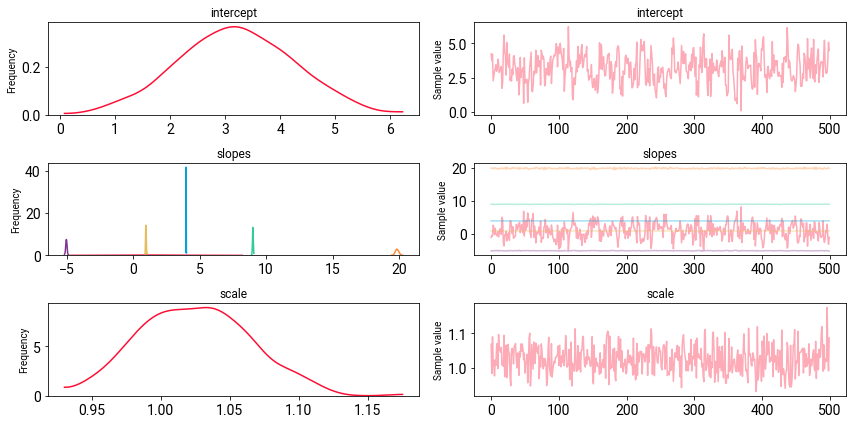

In [21]:
mc.traceplot(samp)

In [22]:
samp['scale'].mean()

1.024695442418421

In [23]:
with mc.Model() as SE:
    intercept = mc.Normal('intercept', 0,sd=10, testval=0)
    slopes = mc.Normal('slopes', 0,sd=10, shape=P)
    s2 = mc.HalfCauchy('scale', 5)
    autoreg = mc.Bound(mc.Normal, lower=1/emin, upper=1/emax)\
                               ('autoreg', mu=0, sd=1, testval=0)
    mean = intercept + tt.dot(X, slopes)
    outcome = eigval_dists.SAR_Error('outcome', mean=mean, scale=s2, 
                                     autoreg=autoreg, weights=W, eigs=evals,
                                     observed=Yknown_e)

In [ ]:
with SE:
    samp = mc.sample(500, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/lw17329/anaconda/envs/ana/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


In [ ]:
mc.traceplot(samp)